<a id='setup'></a>
#Initial setup 


In [2]:
# -- MAIN IMPORT

import pyVHR as vhr
import numpy as np
import matplotlib.pyplot as plt

# Plotting: set 'colab' for Google Colaboratory, 'notebook' otherwise
vhr.plot.VisualizeParams.renderer = 'colab'  # or 'notebook'

2022-09-08 11:16:16.006644: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


In [5]:
# -- LOAD A DATASET

dataset_name = 'ubfc2'                   # the name of the python class handling it 
#video_DIR = '/var/datasets/VHR1/UBFC1/'  # dir containing videos
#BVP_DIR = '/var/datasets/VHR1/UBFC1/'    # dir containing BVPs GT
video_DIR = 'datasets/UBFC-RPPG/d2'
BVP_DIR = 'datasets/UBFC-RPPG/d2' 


dataset = vhr.datasets.datasetFactory(dataset_name, videodataDIR=video_DIR, BVPdataDIR=BVP_DIR)
allvideo = dataset.videoFilenames

# print the list of video names with the progressive index (idx)
for v in range(len(allvideo)):
  print(v, allvideo[v])
print()

0 datasets/UBFC-RPPG/d2/subject3/vid.avi
1 datasets/UBFC-RPPG/d2/subject8/vid.avi
2 datasets/UBFC-RPPG/d2/subject15/vid.avi
3 datasets/UBFC-RPPG/d2/subject4/vid.avi
4 datasets/UBFC-RPPG/d2/subject20/vid.avi
5 datasets/UBFC-RPPG/d2/subject16/vid.avi
6 datasets/UBFC-RPPG/d2/subject1/vid.avi
7 datasets/UBFC-RPPG/d2/subject12/vid.avi
8 datasets/UBFC-RPPG/d2/subject13/vid.avi
9 datasets/UBFC-RPPG/d2/subject9/vid.avi
10 datasets/UBFC-RPPG/d2/subject14/vid.avi
11 datasets/UBFC-RPPG/d2/subject5/vid.avi
12 datasets/UBFC-RPPG/d2/subject10/vid.avi
13 datasets/UBFC-RPPG/d2/subject11/vid.avi
14 datasets/UBFC-RPPG/d2/subject17/vid.avi
15 datasets/UBFC-RPPG/d2/subject22/vid.avi
16 datasets/UBFC-RPPG/d2/subject18/vid.avi



In [6]:
bvp_signals = vhr.datasets.ubfc2.UBFC2(videodataDIR= video_DIR, BVPdataDIR= BVP_DIR)


In [7]:
dd = bvp_signals.readSigfile('./datasets/UBFC-RPPG/d2/subject1/ground_truth.txt')

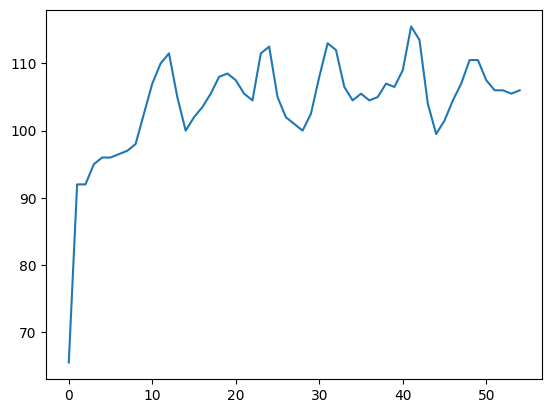

In [8]:
plt.figure(1)
plt.plot(dd.getBPM()[1],dd.getBPM()[0])

In [9]:
# -- PARAMETER SETTING

wsize = 6           # seconds of video processed (with overlapping) for each estimate 
video_idx = 0      # index of the video to be processed
fname = dataset.getSigFilename(video_idx)
sigGT = dataset.readSigfile(fname)
bpmGT, timesGT = sigGT.getBPM(wsize)
videoFileName = dataset.getVideoFilename(video_idx)
print('Video processed name: ', videoFileName)
fps = vhr.extraction.get_fps(videoFileName)
print('Video frame rate:     ',fps)

Video processed name:  datasets/UBFC-RPPG/d2/subject3/vid.avi
Video frame rate:      29.548271


In [16]:
# -- DISPLAY VIDEO FRAMES

vhr.plot.display_video(videoFileName)

interactive(children=(IntSlider(value=0, description='x', max=1800), Output()), _dom_classes=('widget-interact…

# MTTS-CAN

**DeepPhys: Video-Based Physiological Measurement Using Convolutional Attention Networks**

*Weixuan Chen and Daniel McDuff*

**Abstract**. Non-contact video-based physiological measurement has many applications in health care and human-computer interaction. Practical applications require measurements to be accurate even in the presence of large head rotations. We propose the first end-to-end system for video-based measurement of heart and breathing rate using a deep convolutional network. The system features a new motion representation based on a skin reflection model and a new attention mechanism using appearance information to guide motion estimation, both of which enable robust measurement under heterogeneous lighting and major motions. Our approach significantly outperforms all current state-of-the-art methods on both RGB and infrared video datasets. Furthermore, it allows spatial-temporal distributions of physiological signals to be visualized via the attention mechanism.

papers: 
* [DeepPhys: Video-Based Physiological Measurement Using Convolutional Attention Networks](https://web.media.mit.edu/~cvx/docs/18.Chen-etal-ECCV.pdf), 
* [Multi-Task Temporal Shift Attention Networks for On-Device Contactless Vitals Measurement
](https://papers.nips.cc/paper/2020/file/e1228be46de6a0234ac22ded31417bc7-Paper.pdf)


In [28]:
# extract raw frames
sp = vhr.extraction.sig_processing.SignalProcessing()
frames = sp.extract_raw_holistic(videoFileName)
print('Frames shape:', frames.shape)

# apply MTTS_CAN model
bvp_pred = vhr.deepRPPG.MTTS_CAN_deep(frames, fps, verb=1)
bvps = vhr.BPM.BVPsignal(bvp_pred, fps) # BVP object


Frames shape: (1801, 480, 640, 3)
18/18 [==============================] - 1s 33ms/step


In [29]:
vhr.plot.visualize_BVPs([bvps.data], 0)

In [19]:
bvps.data

array([[ 0.09684351,  0.37588654,  0.64708402, ..., -0.11338214,
        -0.05002535,  0.05943296]])

In [12]:
## -- analysis
from pyVHR.utils.errors import getErrors, printErrors, displayErrors, BVP_windowing
from pyVHR.extraction.utils import  sliding_straded_win_idx  # sliding_straded_win_offline

# BVP windowing & BPM estimate
winSizeGT = 30
bvp_win, timesES = BVP_windowing(bvp_pred, winSizeGT, fps, stride=1)
bpmES = vhr.BPM.BVP_to_BPM(bvp_win, fps) 

# compute and print errors
RMSE, MAE, MAX, PCC, CCC, SNR = vhr.utils.getErrors(bvp_win, fps, bpmES, bpmGT, timesES, timesGT)
vhr.utils.printErrors(RMSE, MAE, MAX, PCC, CCC, SNR)
displayErrors(bpmES, bpmGT, timesES, timesGT)


    * Errors: RMSE = 44.02, MAE = 31.24, MAX = 147.21, PCC = 0.20, CCC = 0.08, SNR = -5.77


# Pipeline

In [13]:
def plot_bpm(t,b,title,s = [], h = []):
    plt.figure(1)
    plt.xlabel('time')
    plt.ylabel('BPM')
    plt.title(title)

    plt.plot(t, b, label = "Model HR")
    if s and h:
        plt.plot(s, h, label = "Oxicometer")

    plt.legend()
    plt.show()

In [25]:
import xml.etree.ElementTree as ET

cmsTree = ET.parse('datasets/LGI-PPGI/alex/alex_gym/cms50_stream_handler.xml')

cmsFrames = [] #60 fps

myroot = cmsTree.getroot()
for i in range(len(myroot)):
    cmsFrames.append([int(myroot[i][0].text),int(myroot[i][1].text),int(myroot[i][2].text)])
    

frames= [] 
secs = []
cms_cap = []
hr = []
for i in range(len(cmsFrames)):
#for i in range(2000):    
    frames.append(cmsFrames[i][0]) # frame
    hr.append(cmsFrames[i][1]) # heart rate
    cms_cap.append(cmsFrames[i][2]) # data captured
    secs.append(cmsFrames[i][0]/60)

print("x lnegh: ", len(frames))
print("cap lnegh: ", len(cms_cap))
print("hr lnegh: ", len(hr) )

x lnegh:  24118
cap lnegh:  24118
hr lnegh:  24118


### Exceso de memoria

In [26]:
# run on a single video
from pyVHR.analysis.pipeline import DeepPipeline

filename = '/LGI-PPGI/alex/alex_gym/cv_camera_sensor_stream_handler.avi'
#filename = './datasets/v1.mp4'
#filename = './datasets/UBFC-RPPG/d2/subject1/vid.avi'

pipe = DeepPipeline()

time, BPM = pipe.run_on_video(filename, method='MTTS_CAN')


Processing Video: /LGI-PPGI/alex/alex_gym/cv_camera_sensor_stream_handler.avi
Frames shape: (0,)

BVP extraction with method: MTTS_CAN


[ERROR:0@583.392] global /io/opencv/modules/videoio/src/cap.cpp (164) open VIDEOIO(CV_IMAGES): raised OpenCV exception:

OpenCV(4.6.0) /io/opencv/modules/videoio/src/cap_images.cpp:253: error: (-5:Bad argument) CAP_IMAGES: can't find starting number (in the name of file): /LGI-PPGI/alex/alex_gym/cv_camera_sensor_stream_handler.avi in function 'icvExtractPattern'


[ERROR:0@583.392] global /io/opencv/modules/videoio/src/cap.cpp (164) open VIDEOIO(CV_IMAGES): raised OpenCV exception:

OpenCV(4.6.0) /io/opencv/modules/videoio/src/cap_images.cpp:253: error: (-5:Bad argument) CAP_IMAGES: can't find starting number (in the name of file): /LGI-PPGI/alex/alex_gym/cv_camera_sensor_stream_handler.avi in function 'icvExtractPattern'




IndexError: tuple index out of range

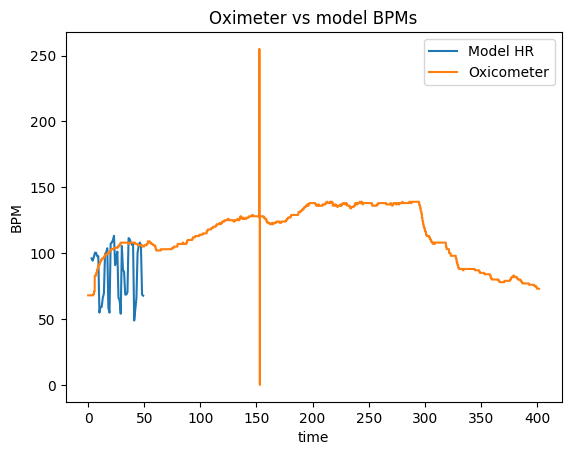

In [27]:
plot_bpm(time,BPM,'Oximeter vs model BPMs', secs, hr)

### Video V1.mp4

In [14]:
# run on a single video
from pyVHR.analysis.pipeline import DeepPipeline

filename = './datasets/v1.mp4'

pipe = DeepPipeline()

v1_time, v1_BPM = pipe.run_on_video(filename, method='MTTS_CAN')


Processing Video: ./datasets/v1.mp4
Frames shape: (194, 720, 1280, 3)

BVP extraction with method: MTTS_CAN
2/2 [==============================] - 0s 35ms/step

BPM estimation with: welch

...done!



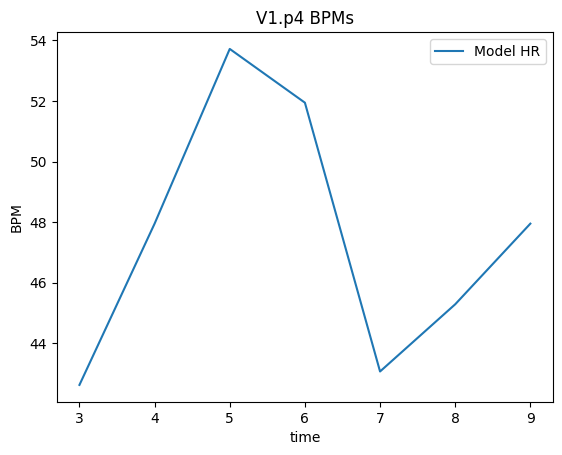

In [36]:
plot_bpm(v1_time,v1_BPM,'V1.p4 BPMs')